#### Mounting Drive and Imports


In [12]:
#@title Mount Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Creating the CSV files (Only One time Operation,Dont Run Now)

In [14]:
#@title Creating Testing Csv file
import os

paths = []
types = []
labels = []
label = 0

path = "/content/drive/MyDrive/tumourdataset/Testing"
for folder in os.listdir(path):
  for file1 in os.listdir(path+"/"+folder):
      paths.append(file1) 
      types.append(folder)
      labels.append(label)
  
  label+=1

df = pd.DataFrame() 

df["Name"] = paths
df["Type"] = types
df["Label"] = labels
df.to_csv(path+"/testingData.csv")

In [ ]:
#@title Creating Training Csv file
import os 


paths = []
types = []
labels = []
label = 0

path = "/content/drive/MyDrive/tumourdataset/Training"
for folder in os.listdir(path):
  for file1 in os.listdir(path+"/"+folder):
    paths.append(file1)
    types.append(folder)
    labels.append(label)
  
  label+=1

df = pd.DataFrame()
df["Name"] = paths
df["Type"] = types
df["Label"] = labels
df.to_csv(path+"/trainingData.csv")

In [27]:
import os

paths = []
types = []
labels = []
label = 0

path = "/content/drive/MyDrive/tumourdataset/Testing"
for folder in os.listdir(path):
  for file1 in os.listdir(path+"/"+folder):
      paths.append(file1)
      if folder== "meningioma" :
        types.append(folder)  
        labels.append(0)
      elif folder == "pituitary" : 
        types.append(folder)
        labels.append(1)
      elif folder== "glioma" : 
        types.append(folder)
        labels.append(2) 
      elif folder== "notumor" : 
        types.append(folder)
        labels.append(3)  
  


df = pd.DataFrame() 

df["Name"] = paths
df["Type"] = types
df["Label"] = labels
df.to_csv(path+"/testingData.csv")

In [ ]:
#@title Old Loading Method
from PIL import Image
images = []
labels = []
path = "/content/drive/MyDrive/tumourdataset/Training"
for i in range(500):
  image = np.array(Image.open(path +"/" + data["Type"][i] + "/"+ data["Name"][i]).convert("RGB").resize((224,224)))/255
  label = data["Label"][i]
  images.append(image)
  labels.append(label)



####Loading the Data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/tumourdataset/Training/trainingData.csv")

In [28]:
data = pd.read_csv("/content/drive/MyDrive/tumourdataset/Testing/testingData.csv")

In [ ]:
#@title New Loading Method
from PIL import Image
names = np.concatenate((data[data["Type"] == "meningioma"]["Name"][:500],
                       data[data["Type"] == "glioma"]["Name"][:500],
                       data[data["Type"] == "pituitary"]["Name"][:500],
                       data[data["Type"] == "notumor"]["Name"][:500]))

images = []
labels = []
path = "/content/drive/MyDrive/tumourdataset/Training"

for i in range(len(names)):
  idx  = int(np.array(data[data["Name"] == names[i]].index))
  image = np.array(Image.open(path +"/" + data["Type"][idx] + "/"+ data["Name"][idx]).convert("RGB").resize((224,224)))/255
  label = data["Label"][idx]
  images.append(image)
  labels.append(label)

In [29]:
from PIL import Image
names = np.concatenate((data[data["Type"] == "meningioma"]["Name"][0:],
                       data[data["Type"] == "glioma"]["Name"][0:],
                       data[data["Type"] == "pituitary"]["Name"][0:],
                       data[data["Type"] == "notumor"]["Name"][0:]))

images = []
labels = []
path = "/content/drive/MyDrive/tumourdataset/Testing"

for i in range(len(names)):
  idx  = int(np.array(data[data["Name"] == names[i]].index))
  image = np.array(Image.open(path +"/" + data["Type"][idx] + "/"+ data["Name"][idx]).convert("RGB").resize((224,224)))/255
  label = data["Label"][idx]
  images.append(image)
  labels.append(label)

In [ ]:
len(pd.Series(names).unique())

2000

In [22]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(images,labels,test_size = 0.999,random_state = 42,shuffle = True)

In [ ]:
#dataset = tf.data.Dataset.from_tensor_slices((np.array(images),labels)).shuffle(buffer_size = 5000)
test_batches = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(32)
train_batches = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32)

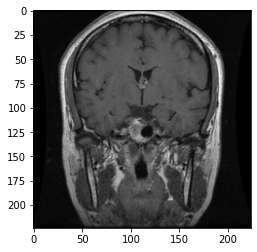

In [ ]:
plt.imshow(images[1472])

In [ ]:
import sys
sys.getsizeof(images)

16568

#### Creating Model

In [18]:
IMG_SHAPE = (224,224,3)

conv_layer = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                  include_top = False,
                                                  weights = "imagenet")
conv_layer.trainable = False

pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
hidden_layer = tf.keras.layers.Dense(32,activation = "relu")
output_layer = tf.keras.layers.Dense(4,activation="softmax")
model = tf.keras.Sequential([
    conv_layer,
    pooling_layer,
    hidden_layer,
    output_layer
])

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 2,299,108
Trainable params: 41,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001),
              loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ["accuracy"]
)

In [ ]:
model.load_weights('/content/drive/MyDrive/tumourdataset/checkpoints/mobilenetv2_80epochs')

In [ ]:
# partially trained weights contains 4000 images
model.load_weights('/content/drive/MyDrive/tumourdataset/checkpoints/mobilenetv2_12epochs')

In [20]:
# completely trained weights contains complete 5712 images from now on use this as it contains modified weights corresponding to all the images
model.load_weights('/content/drive/MyDrive/tumourdataset/checkpoints/mobilenetv2_12epochs')

#### Training the Model

In [ ]:
epochs = 25

In [ ]:
history = model.fit(train_batches,epochs = epochs)

In [ ]:
loss,acc = model.evaluate(test_batches)

In [ ]:
X_train = []
X_test = []
y_test = []
y_train = []

In [ ]:
from PIL import Image
names = np.concatenate((data[data["Type"] == "meningioma"]["Name"][500:1000],
                       data[data["Type"] == "glioma"]["Name"][500:1000],
                       data[data["Type"] == "pituitary"]["Name"][500:1000],
                       data[data["Type"] == "notumor"]["Name"][500:1000]))

images = []
labels = []
path = "/content/drive/MyDrive/tumourdataset/Training"

for i in range(len(names)):
  idx  = int(np.array(data[data["Name"] == names[i]].index))
  image = np.array(Image.open(path +"/" + data["Type"][idx] + "/"+ data["Name"][idx]).convert("RGB").resize((224,224)))/255
  label = data["Label"][idx]
  images.append(image)
  labels.append(label)

In [ ]:
from sklearn.model_selection import train_test_split

X_train1,X_test1,y_train1,y_test1 = train_test_split(images,labels,test_size = 0.0005,random_state = 42,shuffle = True)

In [ ]:
test_batches1 = tf.data.Dataset.from_tensor_slices((X_test1,y_test1)).batch(32)
train_batches1 = tf.data.Dataset.from_tensor_slices((np.array(X_train1),y_train1)).batch(32)

In [ ]:
history = model.fit(train_batches1,epochs = epochs)

Epoch 1/25
63/63 [==============================] - 84s 1s/step - loss: 0.1267 - accuracy: 0.9550
Epoch 2/25
63/63 [==============================] - 102s 2s/step - loss: 0.0705 - accuracy: 0.9710
Epoch 3/25
63/63 [==============================] - 105s 2s/step - loss: 0.0540 - accuracy: 0.9815
Epoch 4/25
63/63 [==============================] - 102s 2s/step - loss: 0.0469 - accuracy: 0.9840
Epoch 5/25
63/63 [==============================] - 100s 2s/step - loss: 0.0425 - accuracy: 0.9880
Epoch 6/25
63/63 [==============================] - 80s 1s/step - loss: 0.0390 - accuracy: 0.9895
Epoch 7/25
63/63 [==============================] - 81s 1s/step - loss: 0.0361 - accuracy: 0.9910
Epoch 8/25
63/63 [==============================] - 81s 1s/step - loss: 0.0337 - accuracy: 0.9935
Epoch 9/25
63/63 [==============================] - 83s 1s/step - loss: 0.0316 - accuracy: 0.9940
Epoch 10/25
63/63 [==============================] - 81s 1s/step - loss: 0.0299 - accuracy: 0.9950
Epoch 11/25
63/

In [ ]:
model.save_weights('/content/drive/MyDrive/tumourdataset/checkpoints/mobilenetv2_12epochs')

In [ ]:
X_train1 = []
X_test1 = []
y_test1 = []
y_train1 = []

In [ ]:
from PIL import Image
names = np.concatenate((data[data["Type"] == "meningioma"]["Name"][1000:],
                       data[data["Type"] == "glioma"]["Name"][1000:],
                       data[data["Type"] == "pituitary"]["Name"][1000:],
                       data[data["Type"] == "notumor"]["Name"][1000:]))

images = []
labels = []
path = "/content/drive/MyDrive/tumourdataset/Training"

for i in range(len(names)):
  idx  = int(np.array(data[data["Name"] == names[i]].index))
  image = np.array(Image.open(path +"/" + data["Type"][idx] + "/"+ data["Name"][idx]).convert("RGB").resize((224,224)))/255
  label = data["Label"][idx]
  images.append(image)
  labels.append(label)

In [ ]:
len(images)

1712

In [ ]:
from sklearn.model_selection import train_test_split

X_train2,X_test2,y_train2,y_test2 = train_test_split(images,labels,test_size = 0.001,random_state = 42,shuffle = True)

In [ ]:
test_batches2 = tf.data.Dataset.from_tensor_slices((np.array(X_test2),y_test2)).batch(32)
train_batches2 = tf.data.Dataset.from_tensor_slices((np.array(X_train2),y_train2)).batch(32)

In [ ]:
epochs = 5

In [ ]:
history = model.fit(train_batches2,epochs = epochs)

In [ ]:
model.save_weights('/content/drive/MyDrive/tumourdataset/checkpoints/mobilenetv2_13epochs')

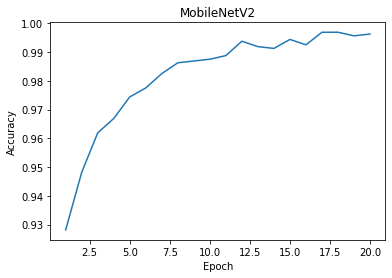

In [ ]:
import matplotlib.pyplot as plt

model_name = "MobileNetV2"

plt.plot([i for i in range(1,epochs+1)],history.history["accuracy"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(model_name)
plt.show()

In [ ]:
model.save_weights(f'/content/drive/MyDrive/checkpoints/mobilenetv2_80+{epochs}epochs')

#### Getting Predictions

In [ ]:
pred = model.predict(train_batches)

In [ ]:
dec = ["meningioma","pituitary","glioma","notumor"]

In [ ]:
dec[list(train_batches.as_numpy_iterator())[0][1][0]]

'meningioma'

In [ ]:
dec[np.argmax(pred[0])]

'pituitary'

In [ ]:
arr = [i for i in range(len(pred)//4) if np.argmax(pred[i]) == 0]

In [ ]:
len(arr)

404

In [ ]:
img = np.array(Image.open(path).convert("RGB").resize((224,224)))/255

In [ ]:
#img = list(train_batches.as_numpy_iterator())[0][0][0]
print(dec[list(train_batches.as_numpy_iterator())[0][1][0]])
pred = model.predict(tf.data.Dataset.from_tensor_slices([img]).batch(1))
dec[np.argmax(pred)]

meningioma


'meningioma'

In [ ]:
pred[0]

array([1.6456012e-06, 3.4959069e-07, 6.4813941e-09, 9.9999797e-01],
      dtype=float32)

In [30]:
from sklearn.metrics import classification_report

pred = model.predict(tf.data.Dataset.from_tensor_slices(images).batch(32))
new_pred = []
for pr in pred:
  new_pred.append(np.argmax(pr))
print(classification_report(labels,new_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       306
           1       0.94      0.97      0.96       300
           2       0.90      0.92      0.91       300
           3       0.96      0.97      0.97       405

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311

